In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

Overall Goal: Predict stock price (high) on day X+1 as precisely as possible

In [8]:
path_to_df = "..\Data\SPX.csv"
df = pd.read_csv(path_to_df)
df = df.iloc[::-1]

df.head()

,Date,Close/Last,Open,High,Low
2530,02/24/2014,1847.61,1836.78,1858.71,1836.78
2529,02/25/2014,1845.12,1847.66,1852.91,1840.19
2528,02/26/2014,1845.16,1845.79,1852.65,1840.66
2527,02/27/2014,1854.29,1844.90,1854.53,1841.13
2526,02/28/2014,1859.45,1855.12,1867.92,1847.67


In [4]:
def plot_chart(df, col):
    # Create a larger plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plotting the 'X' column against dates
    ax.plot(df['Date'], df[col])
    ax.set_title('Plot of X Column over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('X Values')

    # Automatically set the x-axis date labels based on available space
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show() 

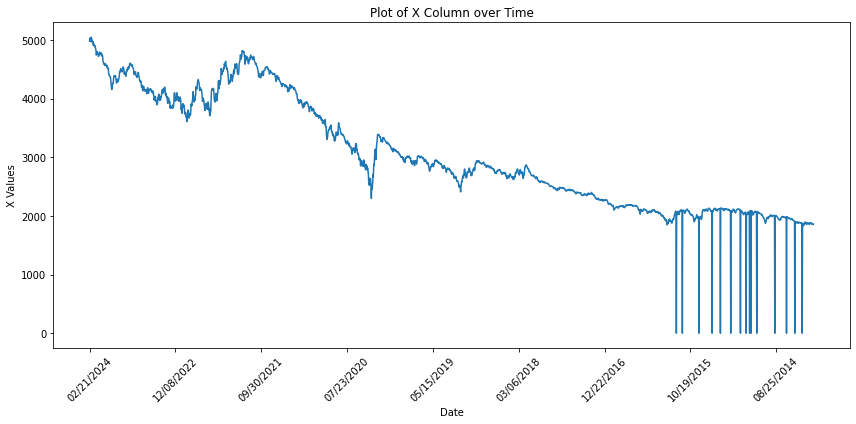

In [5]:
plot_chart(df, "High")

In [53]:
#Technique 1: Linear Regression
#fit model to the last X days
#use model to predict price on day X+1

model = LinearRegression()

stock_prices = df["Close"].values
X = 5
predicted_stock_prices = []

for ind, _ in enumerate(stock_prices):
    if ind >= len(stock_prices) - X:
        break
    prices = stock_prices[ind:ind + X]
    days = np.arange(X).reshape(-1, 1)
    model.fit(days, prices)
    y_pred = model.predict(np.array(X + 1).reshape(-1, 1))
    predicted_stock_prices.append(y_pred[0])

predicted_stock_prices = np.array(predicted_stock_prices)

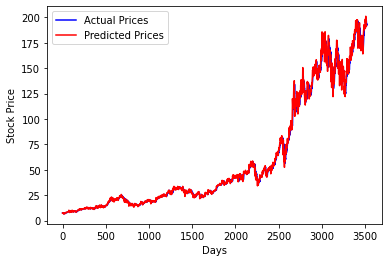

: 

In [55]:
# Plot the actual stock prices in blue
plt.plot(df["Close"], color='blue', label='Actual Prices')

# Plot the predicted prices in red
plt.plot(predicted_stock_prices, color='red', label='Predicted Prices')

# Add labels and legend
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()

# Show the plot
plt.show()